# Conjuntos de dados N-dimensionais (parte 2)

Vamos trabalhar ainda com imagens, mas agora com o CCDData. Um objeto CCDData também pode armazenar dados, uma máscara e metadados. O objeto CCDData requer que uma unidade seja definida.\
Para iniciar, vamos fazer o objeto data do notebook anterior:

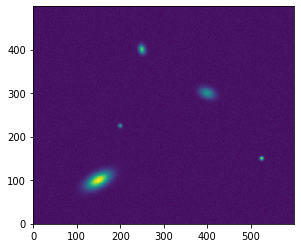

In [11]:
#Refazendo "data" do notebook anterior
import numpy as np
from astropy.modeling.models import Gaussian2D
y, x = np.mgrid[0:500, 0:600]
data = (Gaussian2D(1, 150, 100, 20, 10, theta=0.5)(x, y) +
        Gaussian2D(0.5, 400, 300, 8, 12, theta=1.2)(x,y) +
        Gaussian2D(0.75, 250, 400, 5, 7, theta=0.23)(x,y) +
        Gaussian2D(0.9, 525, 150, 3, 3)(x,y) +
        Gaussian2D(0.6, 200, 225, 3, 3)(x,y))
data += 0.01 * np.random.randn(500, 600)
cosmic_ray_value = 0.997
data[100, 300:310] = cosmic_ray_value
mask = (data == cosmic_ray_value)

import matplotlib.pyplot as plt
plt.imshow(data, origin='lower')

In [7]:
from astropy.nddata import CCDData
#Fazendo um objeto CDDData com os dados
ccd = CCDData(data, mask=mask, meta={'object': 'fake galaxy', 'filter': 'R'}, unit='adu')

In [8]:
print(ccd)
print(type(ccd))

[[ 0.00497084 -0.00480116  0.00446414 ... -0.00218256  0.02757969
  -0.00809976]
 [-0.01212693 -0.01465943  0.0083482  ...  0.00042089 -0.01778149
  -0.01245593]
 [-0.00187069 -0.00282384  0.00887511 ...  0.01055792 -0.02161186
  -0.00119005]
 ...
 [ 0.00885913 -0.0030941  -0.01244084 ...  0.00209087 -0.00079469
   0.01608445]
 [ 0.01963744  0.00776685 -0.00329356 ... -0.0012373  -0.00686027
  -0.01334256]
 [-0.01086594  0.00172579  0.01257825 ... -0.00702011 -0.01628517
   0.02976939]]
<class 'astropy.nddata.ccddata.CCDData'>


É possível selecionar só as partes que você quiser também, como o que fizemos anteriormente.

In [9]:
ccd2 = ccd[:200, :]
print(ccd2.data.shape)
print(ccd2.mask.shape)

(200, 600)
(200, 600)
[[False False False False False False False False False False False False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False False False False False False False False False False False False]]


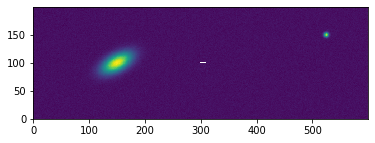

In [14]:
#Sempre é bom dar uma olhado no que acontece visualmente:
plt.imshow(ccd2, origin='lower')

Vamos mostrar agora uma região ao redor do raio cósmico:

In [12]:
print(ccd2.mask[99:102, 299:311])

[[False False False False False False False False False False False False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False False False False False False False False False False False False]]


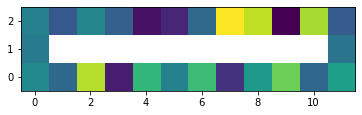

In [15]:
plt.imshow(ccd2[99:102, 299:311], origin='lower')

Ou seja, ampliamos a foto até a região onde se encontra aquele "raio cósmico" que fizemos. Para muitas aplicações, pode ser mais conveniente usar Cutout2D, que explicaremos daqui a pouco.

### Aritmética de imagem, incluindo incerteza

A biblioteca Astropy oferece métodos para operações aritméticas básicas entre imagens, incluindo propagação de incertezas. Três tipos de incerteza são suportados: variância (VarianceUncertainty), desvio padrão (StdDevUncertainty) e a variância inversa (InverseVariance).

Este exemplo cria uma incerteza que é um erro de Poisson¹, armazenado como uma variação:

In [19]:
from astropy.nddata import VarianceUncertainty
import numpy as np

#Usaremos o np.ma.sqrt para raiz e np.ma.abs para obter valor posito (módulo):
print(np.ma.sqrt(16))
print(np.ma.abs(-23))

4.0
23


In [22]:
poisson_noise = np.ma.sqrt(np.ma.abs(ccd.data))
ccd.uncertainty = VarianceUncertainty(poisson_noise ** 2)
print (ccd.uncertainty)
print (type(ccd.uncertainty))

VarianceUncertainty([[0.00497084, 0.00480116, 0.00446414, ..., 0.00218256,
                      0.02757969, 0.00809976],
                     [0.01212693, 0.01465943, 0.0083482 , ..., 0.00042089,
                      0.01778149, 0.01245593],
                     [0.00187069, 0.00282384, 0.00887511, ..., 0.01055792,
                      0.02161186, 0.00119005],
                     ...,
                     [0.00885913, 0.0030941 , 0.01244084, ..., 0.00209087,
                      0.00079469, 0.01608445],
                     [0.01963744, 0.00776685, 0.00329356, ..., 0.0012373 ,
                      0.00686027, 0.01334256],
                     [0.01086594, 0.00172579, 0.01257825, ..., 0.00702011,
                      0.01628517, 0.02976939]])
<class 'astropy.nddata.nduncertainty.VarianceUncertainty'>


## Leitura e escrita

Um objeto CCDData pode ser salvo como um arquivo FITS:

In [ ]:
ccd.write('test_file.fits')

É possível ler um arquivo FITS também:

In [ ]:
ccd2 = CCDData.read('test_file.fits')

Para saber mais sobre leitura e escrita:

In [24]:
CCDData.read.help('fits')

CCDData.read(format='fits') documentation

Generate a CCDData object from a FITS file.

Parameters
----------
filename : str
    Name of fits file.

hdu : int, optional
    FITS extension from which CCDData should be initialized. If zero and
    and no data in the primary extension, it will search for the first
    extension with data. The header will be added to the primary header.
    Default is ``0``.

unit : `~astropy.units.Unit`, optional
    Units of the image data. If this argument is provided and there is a
    unit for the image in the FITS header (the keyword ``BUNIT`` is used
    as the unit, if present), this argument is used for the unit.
    Default is ``None``.

hdu_uncertainty : str or None, optional
    FITS extension from which the uncertainty should be initialized. If the
    extension does not exist the uncertainty of the CCDData is ``None``.
    Default is ``'UNCERT'``.

hdu_mask : str or None, optional
    FITS extension from which the mask should be initialized. 

In [26]:
CCDData.write.help('fits')

CCDData.write(format='fits') documentation

Write CCDData object to FITS file.

Parameters
----------
filename : str
    Name of file.

hdu_mask, hdu_uncertainty, hdu_flags : str or None, optional
    If it is a string append this attribute to the HDUList as
    `~astropy.io.fits.ImageHDU` with the string as extension name.
    Flags are not supported at this time. If ``None`` this attribute
    is not appended.
    Default is ``'MASK'`` for mask, ``'UNCERT'`` for uncertainty and
    ``None`` for flags.

key_uncertainty_type : str, optional
    The header key name for the class name of the uncertainty (if any)
    that is used to store the uncertainty type in the uncertainty hdu.
    Default is ``UTYPE``.

    .. versionadded:: 3.1

kwd :
    All additional keywords are passed to :py:mod:`astropy.io.fits`

Raises
-------
ValueError
    - If ``self.mask`` is set but not a `numpy.ndarray`.
    - If ``self.uncertainty`` is set but not a
      `~astropy.nddata.StdDevUncertainty`.
    - If 

### Tratamentos úteis de imagens

##### Recortes de imagem

Embora cortar diretamente seja uma maneira de extrair uma determinada parte, o Cutout2D fornece acesso mais prático aos recortes dos dados.

##### Exemplos

Este exemplo de como extrair a grande "galáxia" na parte inferior esquerda da imagem:

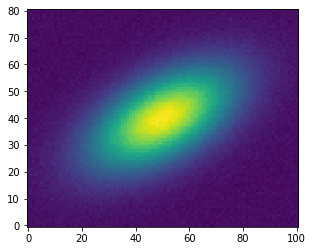

In [32]:
from astropy.nddata import Cutout2D

position = (149.7, 100.1)
size = (81, 101)     # pixels
corte = Cutout2D(ccd, position, size)
plt.imshow(corte.data, origin='lower') 

Mas olha só que interessante: é possível plotar uma borda branca do tamanho do recorte acima em cima da imagem original:

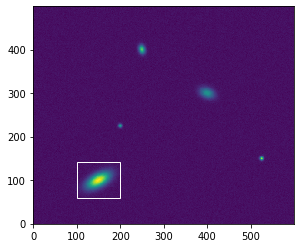

In [37]:
plt.imshow(ccd, origin='lower') #Plotando a imagem
corte.plot_on_original(color='white') #Plotando a moldura

O recorte também fornece métodos para localizar coordenadas de pixel no original ou no recorte; lembre-se de que a posição é o centro do recorte na imagem original:

In [35]:
print(position) #Essa é a posição central do local do corte, tendo como base a imagem central

print(corte.to_cutout_position(position)) #Esse é o centro, mas considerando a segunda imagem.

print(corte.to_original_position((49.7, 40.099999999999994)))

(149.7, 100.1)
(49.69999999999999, 40.099999999999994)
(149.7, 100.1)


Caso queira saber mais sobre esse tratamento de imagens usando Astropy, é só dar uma olhada aqui: https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images

### Redimensionamento de imagem

A biblioteca de Astropy fornece as funções block_reduce e block_replicate para redimensionar imagens.


Este exemplo abaixo reduz o tamanho da imagem por um fator de 4. Observe que o resultado é um objeto numpy.ndarray; a máscara, metadados, etc. então foram descartados (como indica o aviso em vermelho):

[[-0.00553151 -0.05244647  0.01446466 ... -0.09049444 -0.02336109
  -0.01948292]
 [ 0.02365193  0.08814148  0.01020307 ... -0.00198913  0.00872607
  -0.00663878]
 [-0.02534722 -0.03759644  0.02502316 ...  0.01619183 -0.03529085
  -0.00685871]
 ...
 [-0.01274554 -0.04868223  0.04360196 ...  0.01666854  0.02881516
  -0.00867183]
 [ 0.03683049 -0.02625884  0.08008306 ...  0.00082493 -0.01720407
  -0.01550881]
 [-0.00598374  0.081146    0.03549558 ...  0.01245456 -0.00429816
   0.02068542]]


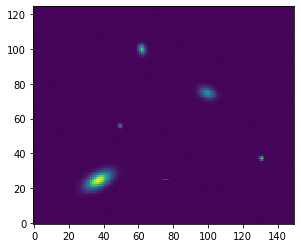

In [39]:
from astropy.nddata import block_reduce, block_replicate

smaller = block_reduce(ccd, 4)  
print(smaller)

plt.imshow(smaller, origin='lower')

# Resumo da parte dois e parte três 

Pode ter ficado um pouco confuso o tratamento de dados com as três formas diferentes discutidas até aqui. Mais ainda: qual o objetivo de cada um?
Essa tradução abaixo do site original exemplifica e resume o que foi visto:

"Existem duas classes menos restritivas, NDDataArray e NDDataRef, que podem ser usadas para armazenar dados de imagem. Elas são mais interesses para aqueles que desejam criar sua própria classe de imagem criando uma subclasse a partir de uma das classes no pacote nddata. As principais diferenças entre eles são:

   $NDDataRef$ pode ser dividido e tem métodos para operações aritméticas básicas, mas o usuário precisa usar uma das classes de incerteza para definir uma incerteza. Consulte NDDataRef para obter mais detalhes. A maioria de suas propriedades deve ser definida quando o objeto é criado, pois elas $não$ $são$ $mutáveis$.

   $NDDataArray$ estende NDDataRef adicionando os métodos necessários para que ele se comporte como uma matriz numpy em expressões e adiciona setters para várias propriedades. Ele não tem a capacidade de $reconhecer$ e $ler$ dados de arquivos FITS automaticamente e não tenta definir automaticamente a propriedade WCS.

   $CCDData$ estende NDDataArray configurando uma classe de incerteza padrão, configurando leitura / gravação direta em arquivos FITS e configurando automaticamente uma propriedade WCS."

Nas fonte abaixo é possível ver um pouco mais sobre o que foi trabalhado até aqui.

1 - A distribuição de Poisson é uma distribuição de probabilidade de variável aleatória discreta que expressa a probabilidade de uma série de eventos ocorrer num certo período de tempo se estes eventos ocorrem independentemente de quando ocorreu o último evento.
Veja mais em: https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_de_Poisson

Fontes do texto:
1 - ASTROPY. "N-Dimensional Datasets (astropy.nddata)". Disponível em: < https://docs.astropy.org/en/stable/nddata/index.html >. Acesso em: 27 de novembro de 2020.

Fontes do código:
ASTROPY. "N-Dimensional Datasets (astropy.nddata)". Disponível em: < https://docs.astropy.org/en/stable/nddata/index.html >. Acesso em: 27 de novembro de 2020.
